# Imports

In [172]:
%load_ext autoreload
%autoreload 2

# Pandas and numpy
import pandas as pd
import numpy as np

# Libraries for Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from src.visualization.visualize import plot_corr_matrix, plot_multi, plot_norm_dist, plot_feature_importances

# Alpaca API
import alpaca_trade_api as tradeapi

# Pickle
import pickle
import os
from pathlib import Path

# To load variables from .env file into system environment
from dotenv import find_dotenv, load_dotenv

from atomm.Indicators import MomentumIndicators
from atomm.DataManager.main import MSDataManager
from atomm.Tools import calc_open_position
from src.visualization.visualize import plot_confusion_matrix

import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# Load environment variables
load_dotenv(find_dotenv())

True

## Defining functions

In [170]:
ti_list = ['macd', 'rsi', 'stoc', 'roc', 'bbu', 'bbl', 'ema', 'atr', 'adx', 'cci', 'williamsr', 'stocd']

def run_combinations(
        symbol,
        forecast_horizon,
        input_window_size,
        X_train,
        X_test,
        y_train,
        y_test,
        prices,
        model,
        plot_results = True
    ):
    start = time.time()
    cnt = 1
    df_score = pd.DataFrame(index=forecast_horizon, columns=input_window_size, dtype=float)
    df_score.rename_axis('Forecast horizon (days)').rename_axis('Input window (days)', axis=1)
    df_returns = df_score.copy()
    for i, fh in enumerate(forecast_horizon):
        for j, iw in enumerate(input_window_size):
            clear_output(wait=True)
            total = len(forecast_horizon)*len(input_window_size)
            model.fit(X_train[[f'{symbol}_{x}_{iw}' for x in ti_list]], y_train[f'{symbol}_signal_{fh}'])
            y_pred = model.predict(X_test[[f'{symbol}_{x}_{iw}' for x in ti_list]])
            a_score = accuracy_score(y_test[f'{symbol}_signal_{fh}'], y_pred)
            returns = calc_returns(y_pred, prices_test[symbol])
            cum_returns = returns['Cum_Returns_Strat'][-1]
            df_score.iloc[i, j] = a_score
            df_returns.iloc[i, j] = cum_returns
            display(f'Leg [{cnt} / {total}]; Test Score {a_score}; Test Returns {cum_returns}')
            cnt += 1
    if plot_results:

        
        plot_corr_matrix(df_returns, mask_upper=False, show_annot=True)
    print(f'Elapsed time {round(time.time()-start, 0)}s.')
    return df_score, df_returns

In [ ]:
        plt.figure(figsize=(8, 6))
        sns.heatmap(df_score, annot=True, fmt='.2f', cmap='RdBu')
        plt.ylabel('Forecast horizon (days)')
        plt.xlabel('Input window size (days)')
        plt.tight_layout()
        plt.figure(figsize=(8, 6))
        sns.heatmap(df_returns, annot=True, fmt='.2f', cmap='RdBu')
        plt.ylabel('Forecast horizon (days)')
        plt.xlabel('Input window size (days)')
        plt.ylim(len(forecast_horizon)-0.5, -0.5)
        plt.tight_layout()

In [123]:
def calc_returns(signals, prices):
    returns = prices[['Close']].pct_change()
    returns['Signal_Strat'] = calc_open_position(signals)
    returns['Cum_Returns_Strat'] = (returns['Signal_Strat'] * returns['Close']).cumsum()
    returns['Cum_Returns_BH'] = returns['Close'].cumsum()
    return returns

In [121]:
calc_returns(y_pred_rf1, prices_test['AAPL'])

,Close,Signal_Strat,Cum_Returns_Strat,Cum_Returns_BH
Epoch,,,,
2017-12-04 00:00:00+00:00,NaN,1,NaN,NaN
2017-12-05 00:00:00+00:00,-0.000942,1,-0.000942,-0.000942
2017-12-06 00:00:00+00:00,-0.003714,1,-0.004656,-0.004656
2017-12-07 00:00:00+00:00,0.001834,1,-0.002822,-0.002822
2017-12-08 00:00:00+00:00,0.000295,1,-0.002527,-0.002527
...,...,...,...,...
2019-11-27 00:00:00+00:00,0.013432,1,0.411195,0.531509
2019-11-29 00:00:00+00:00,-0.002203,1,0.408992,0.529307
2019-12-02 00:00:00+00:00,-0.011562,1,0.397430,0.517744


In [106]:
y_pred_rf1

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  0,  0,  0,  0,  1,  1,  0,  0,  1,  0,  0,
        0,  0,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,
        1,  1,  1,  1,  1,  1,  1,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1

## Loading the data

In [86]:
# Load dataset from pickle file
data_base_dir = os.environ.get('DATA_DIR_BASE_PATH')
fname = data_base_dir + '/processed/djia_features_2019-12-19.pkl'
X = pickle.load(open(fname, 'rb'))

fname = os.path.join(data_base_dir, 'processed', 'index.h5')
fname = Path(fname)
with pd.HDFStore(fname) as storage:
    djia = storage.get('/nyse/prices')

fname1 = data_base_dir + '/processed/djia_target_y_2c_2019-12-19.pkl'
y_2c = pickle.load(open(fname1, 'rb'))

fname2 = data_base_dir + '/processed/djia_target_y_3c_2019-12-19.pkl'
y_3c = pickle.load(open(fname2, 'rb'))

In [52]:
forecast_horizon = [1, 3, 5, 7, 10, 15, 20, 25, 30]
input_window_size = [3, 5, 7, 10, 15, 20, 25, 30]

## Imputing missing values

In [129]:
X.fillna(0, inplace=True)

In [130]:
X.isna().sum()

AAPL_macd_3          0
AAPL_rsi_3           0
AAPL_stoc_3          0
AAPL_roc_3           0
AAPL_bbu_3           0
                    ..
AAPL_atr_30          0
AAPL_adx_30          0
AAPL_cci_30          0
AAPL_williamsr_30    0
AAPL_stocd_30        0
Length: 96, dtype: int64

## Scaling the features

In [131]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [132]:
#scale = MinMaxScaler()
scale = StandardScaler()

In [133]:
scaled = scale.fit_transform(X)

In [134]:
scaled.shape

(1259, 96)

In [135]:
X_scaled = pd.DataFrame(data=scaled, columns=X.columns)
#X_scaled = X

In [136]:
X_scaled.describe()

,AAPL_macd_3,AAPL_rsi_3,AAPL_stoc_3,AAPL_roc_3,AAPL_bbu_3,AAPL_bbl_3,AAPL_ema_3,AAPL_atr_3,AAPL_adx_3,AAPL_cci_3,...,AAPL_stoc_30,AAPL_roc_30,AAPL_bbu_30,AAPL_bbl_30,AAPL_ema_30,AAPL_atr_30,AAPL_adx_30,AAPL_cci_30,AAPL_williamsr_30,AAPL_stocd_30
count,1.259000e+03,1.259000e+03,1.259000e+03,1.259000e+03,1.259000e+03,1.259000e+03,1.259000e+03,1.259000e+03,1.259000e+03,1259.000000,...,1.259000e+03,1259.000000,1.259000e+03,1.259000e+03,1.259000e+03,1.259000e+03,1.259000e+03,1.259000e+03,1.259000e+03,1259.000000
mean,-2.257483e-17,-1.805986e-16,2.624324e-16,-1.975298e-17,-4.514966e-16,9.029932e-17,-1.805986e-16,-9.029932e-17,-5.079336e-17,0.000000,...,-3.273350e-16,0.000000,1.805986e-16,-6.320952e-16,-9.029932e-17,-9.029932e-17,2.708979e-16,3.104039e-17,1.523801e-16,0.000000
std,1.000397e+00,1.000397e+00,1.000397e+00,1.000397e+00,1.000397e+00,1.000397e+00,1.000397e+00,1.000397e+00,1.000397e+00,1.000397,...,1.000397e+00,1.000397,1.000397e+00,1.000397e+00,1.000397e+00,1.000397e+00,1.000397e+00,1.000397e+00,1.000397e+00,1.000397
min,-4.244608e+00,-1.590405e+00,-1.218516e+00,-3.932869e+00,-3.615020e+00,-3.617862e+00,-1.463713e+00,-1.800343e+00,-1.880164e+00,-1.365737,...,-1.772377e+00,-3.576167,-3.574543e+00,-3.623294e+00,-1.366175e+00,-2.412846e+00,-3.183517e+00,-2.929567e+00,-1.251436e+00,-2.563662
25%,-4.942687e-01,-8.378803e-01,-1.218516e+00,-5.455468e-01,-8.886147e-01,-8.895797e-01,-8.995056e-01,-6.857339e-01,-7.849900e-01,-1.128543,...,-8.994909e-01,-0.570691,-8.957247e-01,-8.597527e-01,-9.143931e-01,-7.283521e-01,-6.913941e-01,-7.537282e-01,-9.178702e-01,-0.700609
50%,4.456633e-02,7.130395e-02,3.266790e-01,1.313548e-02,-1.040914e-01,-1.150638e-01,-1.034485e-01,-2.798650e-01,-1.406114e-01,0.296820,...,2.909114e-01,0.034268,-1.651850e-01,-9.922294e-02,-7.211069e-02,-2.954028e-01,-1.739638e-01,1.895143e-01,-2.581933e-01,0.115431
75%,5.714037e-01,9.450143e-01,9.996023e-01,5.499547e-01,7.447451e-01,6.908476e-01,7.230821e-01,4.196008e-01,6.572791e-01,1.024551,...,9.453681e-01,0.710560,7.741996e-01,7.091943e-01,7.873635e-01,6.610809e-01,4.512680e-01,7.314215e-01,8.451205e-01,0.854512
max,3.258829e+00,1.313392e+00,9.996023e-01,3.486909e+00,2.719927e+00,2.819682e+00,2.758852e+00,4.726595e+00,3.396327e+00,1.131448,...,1.094820e+00,2.189337,2.875550e+00,2.695458e+00,2.681482e+00,3.431211e+00,5.572647e+00,2.799121e+00,1.991276e+00,1.548921


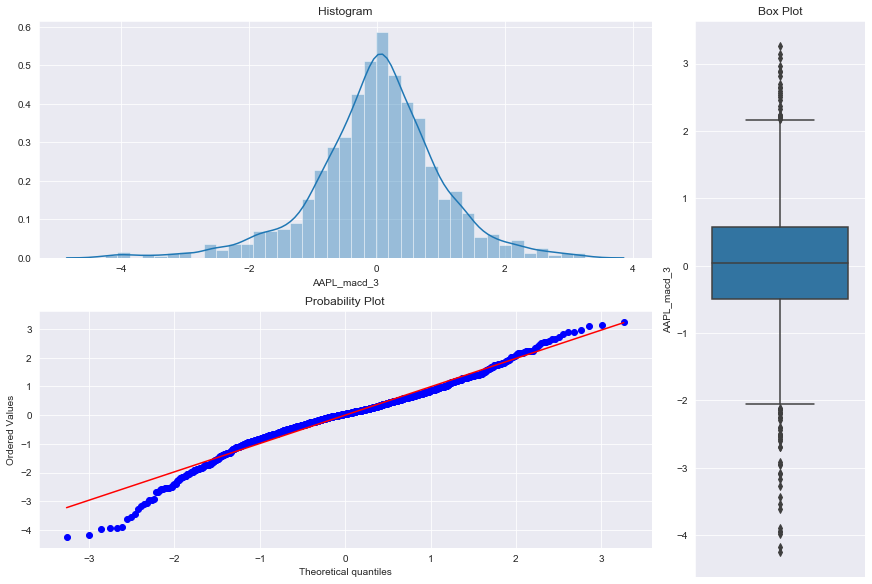

In [137]:
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import matplotlib.gridspec as gridspec
#import matplotlib.style as style
from scipy import stats
sns.set_style('darkgrid')
#style.use('fivethirtyeight')
fig = plt.figure(constrained_layout=True, figsize=(12, 8))
grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)

ax1 = fig.add_subplot(grid[0, :2])
ax1.set_title('Histogram')
sns.distplot(X_scaled['AAPL_macd_3'], norm_hist=False, ax = ax1)

ax2 = fig.add_subplot(grid[1, :2])
ax2.set_title('QQ_plot')
stats.probplot(X_scaled['AAPL_macd_3'], plot = ax2)

ax3 = fig.add_subplot(grid[:, 2])
ax3.set_title('Box Plot')
sns.boxplot(X_scaled['AAPL_macd_3'], orient='v', ax = ax3 );

## Building Machine Learning Models

In [42]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, TimeSeriesSplit

### Train-Test Split

In [138]:
test_p = .4

In [139]:
test_size = int((1 - test_p) * X_scaled.shape[0])
col = 'AAPL_signal_30'
X_train, X_test, y_train, y_test = X_scaled[:test_size], X_scaled[test_size:], y_3c[:test_size], y_3c[test_size:]
prices_train, prices_test = djia[:test_size], djia[test_size:]

In [140]:
X_test.shape

(504, 96)

In [46]:
test_size = test_p
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_3c, test_size=test_size, random_state=101)

In [47]:
X_test.fillna(0, inplace=True)
X_train.fillna(0, inplace=True)

//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/pandas/core/frame.py:4259: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


### LogisticRegression

In [48]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=25, solver='newton-cg')
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print(classification_report(y_test, y_pred_lr))
print(confusion_matrix(y_test, y_pred_lr))

ValueError: bad input shape (755, 18)

### RandomForestClassifier

In [90]:
from sklearn.ensemble import RandomForestClassifier

#### Single combination

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       146
           0       0.16      0.21      0.19        75
           1       0.54      0.76      0.63       283

    accuracy                           0.46       504
   macro avg       0.23      0.32      0.27       504
weighted avg       0.33      0.46      0.38       504

[[  0  21 125]
 [  0  16  59]
 [  8  60 215]]


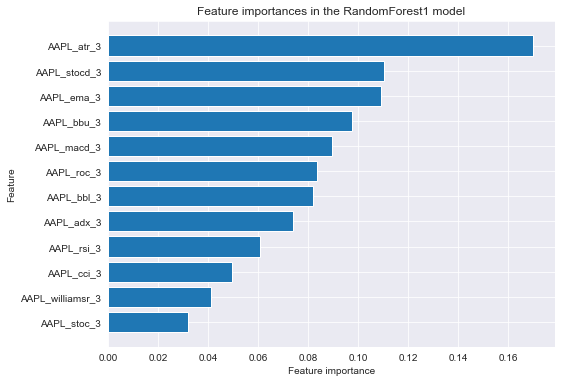

In [93]:

rf1.fit(X_train, y_train)
y_pred_rf1 = rf1.predict(X_test)

symbol = 'AAPL'
col = 'AAPL_signal_30'
n = 30
rf1 = RandomForestClassifier()
rf1.fit(X_train[[f'{symbol}_{x}_{n}' for x in ti_list]], y_train[f'{symbol}_signal_{n}'])
y_pred_rf1 = rf1.predict(X_test[[f'{symbol}_{x}_{n}' for x in ti_list]])

print(classification_report(y_test[f'{symbol}_signal_{n}'], y_pred_rf1))
print(confusion_matrix(y_test[f'{symbol}_signal_{n}'], y_pred_rf1))
plot_feature_importances(rf1.feature_importances_, X_scaled.columns, model='RandomForest1', top_count=100)

In [104]:
calc_returns(y_pred_rf1, prices_test['AAPL'])

KeyError: 'Signals'

#### All combinations

'Leg [72 / 72]; Test Score 0.4583333333333333; Test Returns 0.35416972637176514'

Elapsed time 22.0s.


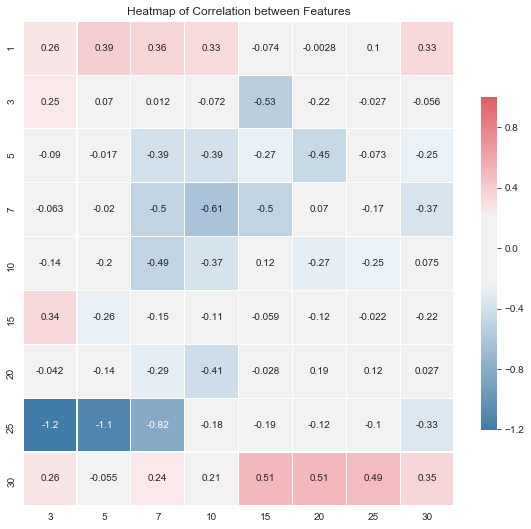

In [174]:
rf2 = RandomForestClassifier(criterion='entropy')
result_matrix = run_combinations(
    'AAPL',
    forecast_horizon,
    input_window_size,
    X_train,
    X_test,
    y_train,
    y_test,
    price_test,
    rf2
)

### XGBoost

#### Single combination

In [871]:
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

symbol = 'AAPL'
col = 'AAPL_signal_3'
xgb = xgb.XGBClassifier(n_jobs=-1)
n = 30
xgb.fit(X_train[[f'{symbol}_{x}_{n}' for x in ti_list]], y_train[f'{symbol}_signal_{n}'])

#param_search = {'max_depth' : [3, 5]}

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [801]:
y_train.shape

(755, 18)

              precision    recall  f1-score   support

          -1       0.83      0.82      0.82       162
           0       0.61      0.25      0.36        55
           1       0.84      0.94      0.89       287

    accuracy                           0.83       504
   macro avg       0.76      0.67      0.69       504
weighted avg       0.81      0.83      0.81       504

[[133   4  25]
 [ 15  14  26]
 [ 13   5 269]]


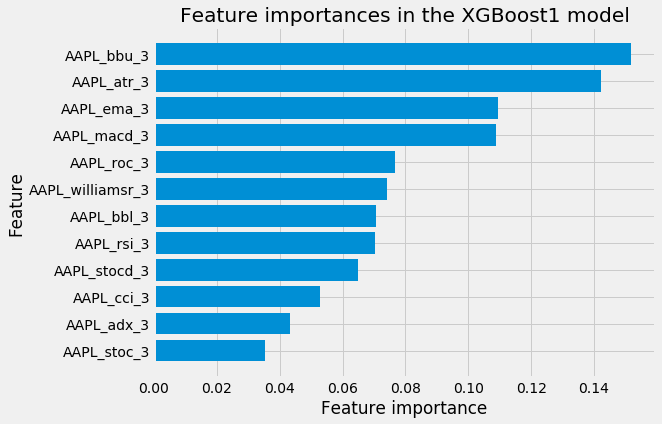

In [802]:
y_pred_xgb = xgb.predict(X_test[[f'{symbol}_{x}_{n}' for x in ti_list]])
print(classification_report(y_test[f'{symbol}_signal_{n}'], y_pred_xgb))
print(confusion_matrix(y_test[f'{symbol}_signal_{n}'], y_pred_xgb))
plot_feature_importances(xgb.feature_importances_, X_scaled.columns, model='XGBoost1', top_count=100)

#### All combinations

In [55]:
from  IPython.display import display, clear_output
import sys
import time

In [64]:
ti_list = ['macd', 'rsi', 'stoc', 'roc', 'bbu', 'bbl', 'ema', 'atr', 'adx', 'cci', 'williamsr', 'stocd']

def run_combinations(
        symbol,
        forecast_horizon,
        input_window_size,
        X_train,
        X_test,
        y_train,
        y_test,
        model,
        plot_results = True
    ):
    start = time.time()
    cnt = 1
    df = pd.DataFrame(index=forecast_horizon, columns=input_window_size, dtype=float)
    df.rename_axis('Forecast horizon (days)').rename_axis('Input window (days)', axis=1)
    for i, fh in enumerate(forecast_horizon):
        for j, iw in enumerate(input_window_size):
            clear_output(wait=True)
            total = len(forecast_horizon)*len(input_window_size)
            model.fit(X_train[[f'{symbol}_{x}_{iw}' for x in ti_list]], y_train[f'{symbol}_signal_{fh}'])
            y_pred = model.predict(X_test[[f'{symbol}_{x}_{iw}' for x in ti_list]])
            a_score = accuracy_score(y_test[f'{symbol}_signal_{fh}'], y_pred)
            df.iloc[i, j] = a_score
            display(f'Leg [{cnt} / {total}]; Test Score {a_score}')
            #sys.stdout.flush()
            cnt += 1
    if plot_results:
        plt.figure(figsize=(8, 6))
        sns.heatmap(df, annot=True, fmt='.2f', cmap='RdBu')
        plt.ylabel('Forecast horizon (days)')
        plt.xlabel('Input window size (days)')
        plt.tight_layout()
    print(f'Elapsed time {round(time.time()-start, 0)}s.')
    return df

In [5]:
xgb_comb = xgb.XGBClassifier(n_jobs=-1)
result_matrix = run_combinations('AAPL', forecast_horizon, input_window_size, X_train, X_test, y_train, y_test, xgb_comb)

NameError: name 'xgb' is not defined

### Support Vector Machine

In [6]:
from sklearn.svm import SVC
svc = SVC()
result_matrix = run_combinations('AAPL', forecast_horizon, input_window_size, X_train, X_test, y_train, y_test, svc)

NameError: name 'forecast_horizon' is not defined

In [696]:
X_test.fillna(0, inplace=True)

In [519]:
X_scaled.columns

Index(['AAPL_macd_36', 'AAPL_rsi_3', 'AAPL_stoc_3', 'AAPL_roc_3', 'AAPL_bbu_3',
       'AAPL_bbl_3', 'AAPL_ema_3', 'AAPL_atr_3', 'AAPL_adx_3', 'AAPL_cci_3',
       'AAPL_williamsr_3', 'AAPL_stocd_3', 'AAPL_macd_510', 'AAPL_rsi_5',
       'AAPL_stoc_5', 'AAPL_roc_5', 'AAPL_bbu_5', 'AAPL_bbl_5', 'AAPL_ema_5',
       'AAPL_atr_5', 'AAPL_adx_5', 'AAPL_cci_5', 'AAPL_williamsr_5',
       'AAPL_stocd_5', 'AAPL_macd_714', 'AAPL_rsi_7', 'AAPL_stoc_7',
       'AAPL_roc_7', 'AAPL_bbu_7', 'AAPL_bbl_7', 'AAPL_ema_7', 'AAPL_atr_7',
       'AAPL_adx_7', 'AAPL_cci_7', 'AAPL_williamsr_7', 'AAPL_stocd_7',
       'AAPL_macd_1020', 'AAPL_rsi_10', 'AAPL_stoc_10', 'AAPL_roc_10',
       'AAPL_bbu_10', 'AAPL_bbl_10', 'AAPL_ema_10', 'AAPL_atr_10',
       'AAPL_adx_10', 'AAPL_cci_10', 'AAPL_williamsr_10', 'AAPL_stocd_10',
       'AAPL_macd_1530', 'AAPL_rsi_15', 'AAPL_stoc_15', 'AAPL_roc_15',
       'AAPL_bbu_15', 'AAPL_bbl_15', 'AAPL_ema_15', 'AAPL_atr_15',
       'AAPL_adx_15', 'AAPL_cci_15', 'AAPL_williamsr_1

### XGBoost with GridSearchCV

In [510]:
param_search = {'max_depth': [3, 5]}
tscv = TimeSeriesSplit(n_splits=2)
gsearch = GridSearchCV(estimator=xgb, cv=tscv,
                        param_grid=param_search)
gsearch.fit(X_scaled, y['AAPL_signal_30'])

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=2),
             error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='multi:softprob',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None, param_grid={'max_depth': [3, 5]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
        

In [512]:
gsearch.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [511]:
y_pred_xgbcv = gsearch.predict(X_test)
print(classification_report(y_test, y_pred_xgbcv))
print(confusion_matrix(y_test, y_pred_xgbcv))
plot_feature_importances(gsearch.feature_importances_, X_scaled.columns, model='XGBoostGridSearchCV', top_count=100)

ValueError: feature_names mismatch: ['AAPL_macd_36', 'AAPL_rsi_3', 'AAPL_stoc_3', 'AAPL_roc_3', 'AAPL_bbu_3', 'AAPL_bbl_3', 'AAPL_ema_3', 'AAPL_atr_3', 'AAPL_adx_3', 'AAPL_cci_3', 'AAPL_williamsr_3', 'AAPL_stocd_3', 'AAPL_macd_510', 'AAPL_rsi_5', 'AAPL_stoc_5', 'AAPL_roc_5', 'AAPL_bbu_5', 'AAPL_bbl_5', 'AAPL_ema_5', 'AAPL_atr_5', 'AAPL_adx_5', 'AAPL_cci_5', 'AAPL_williamsr_5', 'AAPL_stocd_5', 'AAPL_macd_714', 'AAPL_rsi_7', 'AAPL_stoc_7', 'AAPL_roc_7', 'AAPL_bbu_7', 'AAPL_bbl_7', 'AAPL_ema_7', 'AAPL_atr_7', 'AAPL_adx_7', 'AAPL_cci_7', 'AAPL_williamsr_7', 'AAPL_stocd_7', 'AAPL_macd_1020', 'AAPL_rsi_10', 'AAPL_stoc_10', 'AAPL_roc_10', 'AAPL_bbu_10', 'AAPL_bbl_10', 'AAPL_ema_10', 'AAPL_atr_10', 'AAPL_adx_10', 'AAPL_cci_10', 'AAPL_williamsr_10', 'AAPL_stocd_10', 'AAPL_macd_1530', 'AAPL_rsi_15', 'AAPL_stoc_15', 'AAPL_roc_15', 'AAPL_bbu_15', 'AAPL_bbl_15', 'AAPL_ema_15', 'AAPL_atr_15', 'AAPL_adx_15', 'AAPL_cci_15', 'AAPL_williamsr_15', 'AAPL_stocd_15', 'AAPL_macd_2040', 'AAPL_rsi_20', 'AAPL_stoc_20', 'AAPL_roc_20', 'AAPL_bbu_20', 'AAPL_bbl_20', 'AAPL_ema_20', 'AAPL_atr_20', 'AAPL_adx_20', 'AAPL_cci_20', 'AAPL_williamsr_20', 'AAPL_stocd_20', 'AAPL_macd_2550', 'AAPL_rsi_25', 'AAPL_stoc_25', 'AAPL_roc_25', 'AAPL_bbu_25', 'AAPL_bbl_25', 'AAPL_ema_25', 'AAPL_atr_25', 'AAPL_adx_25', 'AAPL_cci_25', 'AAPL_williamsr_25', 'AAPL_stocd_25', 'AAPL_macd_3060', 'AAPL_rsi_30', 'AAPL_stoc_30', 'AAPL_roc_30', 'AAPL_bbu_30', 'AAPL_bbl_30', 'AAPL_ema_30', 'AAPL_atr_30', 'AAPL_adx_30', 'AAPL_cci_30', 'AAPL_williamsr_30', 'AAPL_stocd_30'] ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78', 'f79', 'f80', 'f81', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90', 'f91', 'f92', 'f93', 'f94', 'f95']
expected AAPL_macd_1530, AAPL_stocd_25, AAPL_bbu_20, AAPL_stocd_20, AAPL_adx_3, AAPL_bbl_3, AAPL_roc_7, AAPL_adx_30, AAPL_cci_15, AAPL_stoc_10, AAPL_williamsr_25, AAPL_stoc_25, AAPL_williamsr_20, AAPL_bbl_30, AAPL_adx_20, AAPL_stocd_30, AAPL_stocd_5, AAPL_rsi_10, AAPL_stoc_5, AAPL_atr_30, AAPL_rsi_3, AAPL_bbl_25, AAPL_atr_25, AAPL_atr_20, AAPL_adx_15, AAPL_bbl_5, AAPL_bbu_30, AAPL_ema_25, AAPL_williamsr_15, AAPL_bbu_25, AAPL_rsi_7, AAPL_cci_10, AAPL_atr_5, AAPL_stocd_15, AAPL_roc_3, AAPL_atr_10, AAPL_rsi_20, AAPL_stocd_10, AAPL_bbl_7, AAPL_ema_5, AAPL_stoc_30, AAPL_williamsr_3, AAPL_rsi_15, AAPL_cci_20, AAPL_bbu_15, AAPL_williamsr_10, AAPL_roc_10, AAPL_stoc_3, AAPL_cci_3, AAPL_rsi_5, AAPL_roc_30, AAPL_adx_5, AAPL_bbu_10, AAPL_bbl_20, AAPL_rsi_25, AAPL_adx_10, AAPL_macd_3060, AAPL_ema_30, AAPL_rsi_30, AAPL_atr_7, AAPL_stoc_15, AAPL_ema_3, AAPL_bbu_5, AAPL_williamsr_7, AAPL_stoc_20, AAPL_ema_10, AAPL_stocd_3, AAPL_bbl_15, AAPL_macd_714, AAPL_adx_7, AAPL_macd_36, AAPL_williamsr_30, AAPL_bbl_10, AAPL_cci_30, AAPL_atr_3, AAPL_ema_7, AAPL_macd_510, AAPL_roc_15, AAPL_stoc_7, AAPL_roc_5, AAPL_williamsr_5, AAPL_roc_25, AAPL_ema_15, AAPL_macd_1020, AAPL_bbu_7, AAPL_stocd_7, AAPL_roc_20, AAPL_macd_2550, AAPL_cci_7, AAPL_cci_5, AAPL_adx_25, AAPL_bbu_3, AAPL_cci_25, AAPL_atr_15, AAPL_macd_2040, AAPL_ema_20 in input data
training data did not have the following fields: f10, f94, f64, f38, f17, f85, f44, f81, f59, f3, f70, f82, f76, f18, f53, f55, f37, f62, f24, f22, f48, f66, f27, f13, f8, f34, f19, f86, f92, f58, f36, f80, f39, f77, f90, f88, f65, f20, f7, f87, f46, f72, f0, f78, f6, f5, f74, f33, f15, f40, f63, f54, f41, f12, f4, f71, f75, f95, f29, f14, f23, f73, f30, f50, f68, f45, f9, f60, f25, f16, f43, f11, f21, f47, f61, f89, f49, f93, f69, f26, f91, f79, f32, f83, f84, f2, f28, f67, f31, f56, f1, f57, f35, f42, f52, f51

              precision    recall  f1-score   support

          -1       0.82      0.80      0.81        88
           0       0.76      0.64      0.70       104
           1       0.84      0.93      0.88       186

    accuracy                           0.82       378
   macro avg       0.81      0.79      0.80       378
weighted avg       0.82      0.82      0.82       378

[[ 70  13   5]
 [ 10  67  27]
 [  5   8 173]]


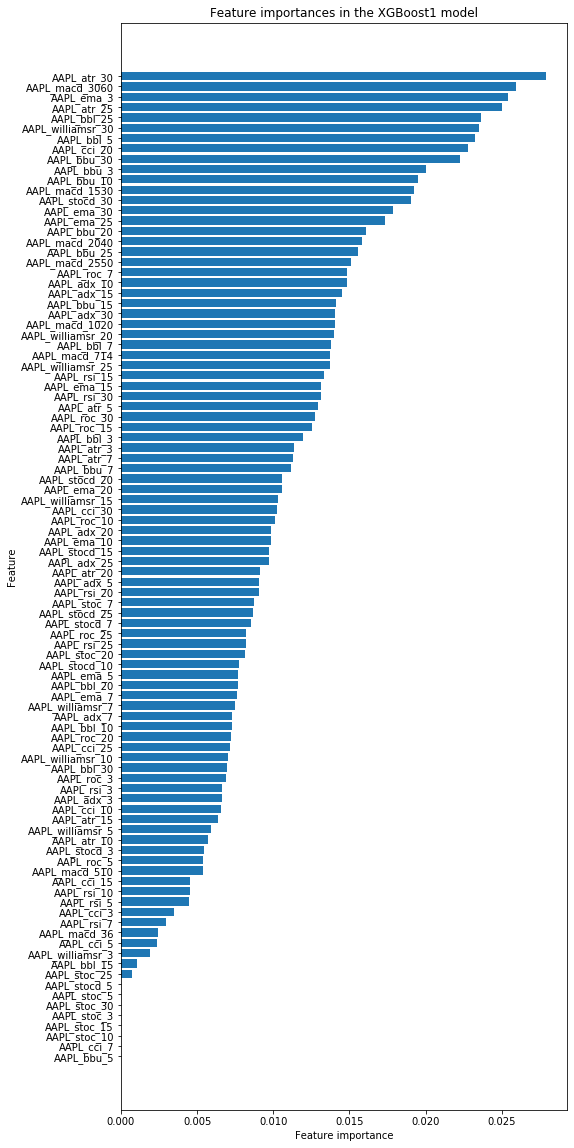

In [498]:
X1 = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
y1 = np.array([1, 2, 3, 4, 5, 6])
tscv = TimeSeriesSplit()
print(tscv)
TimeSeriesSplit(max_train_size=None, n_splits=5)
for train_index, test_index in tscv.split(X1):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X1[train_index], X1[test_index]
    y_train, y_test = y1[train_index], y1[test_index]
    print(X_train, X_test)

TimeSeriesSplit(max_train_size=None, n_splits=5)
TRAIN: [0] TEST: [1]
[[1 2]] [[3 4]]
TRAIN: [0 1] TEST: [2]
[[1 2]
 [3 4]] [[1 2]]
TRAIN: [0 1 2] TEST: [3]
[[1 2]
 [3 4]
 [1 2]] [[3 4]]
TRAIN: [0 1 2 3] TEST: [4]
[[1 2]
 [3 4]
 [1 2]
 [3 4]] [[1 2]]
TRAIN: [0 1 2 3 4] TEST: [5]
[[1 2]
 [3 4]
 [1 2]
 [3 4]
 [1 2]] [[3 4]]


## Unsupervised Learning

### KMeans Clustering

In [738]:
from sklearn.cluster import KMeans

In [763]:
kmeans = KMeans(
    n_clusters=3,
    verbose=0,
    tol=1E-3,
    max_iter=1000,
    n_init=20,
    random_state=3
)

In [764]:
kmeans.fit(X_scaled[['AAPL_macd_10', 'AAPL_williamsr_10']])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
       n_clusters=3, n_init=20, n_jobs=None, precompute_distances='auto',
       random_state=3, tol=0.001, verbose=0)

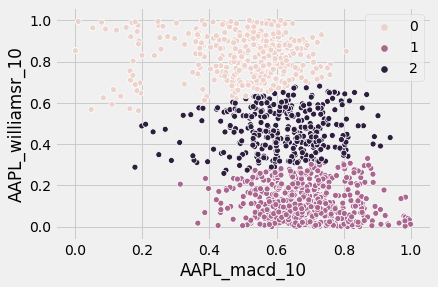

In [765]:
sns.scatterplot(X_scaled['AAPL_macd_10'], X_scaled['AAPL_williamsr_10'], hue=kmeans.labels_)

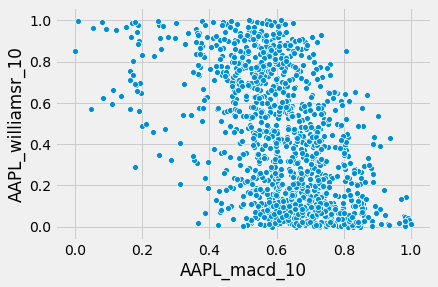

In [766]:
sns.scatterplot(X_scaled['AAPL_macd_10'], X_scaled['AAPL_williamsr_10'])